# SCEPTR UMAP 2D Visualization

This notebook loads a single best-epoch SCEPTR model checkpoint, computes a bag-level embedding (the sparse-attention weighted sum), and then visualises those embeddings in a 2D space using UMAP. Control vs cancer patients are plotted in different colours.


In [11]:
import os
import sys
import torch
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import umap.umap_ as umap

import warnings
warnings.filterwarnings("ignore")

from src.model import sceptr_unidirectional, load_trained
import sceptr

plt.rcParams["figure.figsize"] = (10, 8)
sns.set_style("whitegrid")

## 1. Configuration
- Specify which model checkpoint to load.
- Define paths to evaluation data (`data/beta/sceptr-eval`).


In [12]:
# uncomment/comment accordingly

# alpha
BEST_RUN_INDEX = 0
BEST_EPOCH = 49
chain = 'alpha'

# beta
# BEST_RUN_INDEX = 0
# BEST_EPOCH = 33
# chain = 'beta'

model_dir = Path.cwd() / f"results-new-{chain}" / "sceptr" / f"trained-sceptr-{BEST_RUN_INDEX}" / f"Epoch {BEST_EPOCH}"
model_path = model_dir / f"classifier-{BEST_EPOCH}.pth"

eval_dir = Path.cwd() / "data" / chain / "sceptr-eval"

control_dir = eval_dir / "control"
cancer_dir = eval_dir / "pbmc_cancer"

print(f"Model path: {model_path}")
print(f"Control dir: {control_dir}")
print(f"Cancer dir: {cancer_dir}")

Model path: /cs/student/ug/2022/jpytel/Documents/fyp/TCR-Cancer-Prediction/results-new-alpha/sceptr/trained-sceptr-0/Epoch 49/classifier-49.pth
Control dir: /cs/student/ug/2022/jpytel/Documents/fyp/TCR-Cancer-Prediction/data/alpha/sceptr-eval/control
Cancer dir: /cs/student/ug/2022/jpytel/Documents/fyp/TCR-Cancer-Prediction/data/alpha/sceptr-eval/pbmc_cancer


## 2. Load the Model
Load the trained `sceptr_unidirectional` classifier. The aggregated bag vector is computed in the forward pass by taking `model.last_weights * embeddings` and summing. This logic is replicated below to extract each patient’s final 64‐dim vector.


In [13]:
model = load_trained(
    path_to_trained=model_path,
    hypothesised_model=sceptr_unidirectional
)

model.eval()
print("Loaded model:", model_path)
if torch.cuda.is_available():
    model.cuda()

Loaded model: /cs/student/ug/2022/jpytel/Documents/fyp/TCR-Cancer-Prediction/results-new-alpha/sceptr/trained-sceptr-0/Epoch 49/classifier-49.pth


## 3. Helper Function: Get Bag Vector

1. Takes a dataframe of TCR sequences.
2. Uses `sceptr.calc_vector_representations()` to get a `[N,64]` embedding.
3. Feeds it into the model’s sparsemax aggregator.
4. Returns the single `[1,64]` bag vector.


In [14]:
def get_bag_vector_from_df(df: pd.DataFrame, model: sceptr_unidirectional):
    # convert to embedding using SCEPTR
    embeddings = sceptr.calc_vector_representations(df)
    embeddings_t = torch.from_numpy(embeddings).float()
    if torch.cuda.is_available():
        embeddings_t = embeddings_t.cuda()

    # forward pass
    with torch.no_grad():
        _ = model(embeddings_t)
        bag_vec = model.last_weights * embeddings_t
        bag_vec = bag_vec.sum(dim=0, keepdim=True)
    return bag_vec.cpu().numpy()


## 4. Collect All Patient Bag Vectors
Read every `*.tsv` file from `control` and `pbmc_cancer`. Each file corresponding to one patient. Then:
- compute the `[1,64]` bag vector,
- store it in an array,
- store the label (0=control, 1=cancer)


In [15]:
control_files = sorted(control_dir.glob("*.tsv"))
cancer_files = sorted((cancer_dir).glob("*.tsv"))

bag_vectors = []
labels = []
patient_ids = []

print("Processing control files...")
for f in tqdm(control_files):
    df = pd.read_csv(f, sep="\t")
    vec = get_bag_vector_from_df(df, model)
    bag_vectors.append(vec)
    labels.append(0)
    patient_ids.append(f.stem)

print("Processing cancer files...")
for f in tqdm(cancer_files):
    df = pd.read_csv(f, sep="\t")
    vec = get_bag_vector_from_df(df, model)
    bag_vectors.append(vec)
    labels.append(1)
    patient_ids.append(f.stem)

bag_vectors = np.concatenate(bag_vectors, axis=0)  # shape [num_patients, 64]
labels = np.array(labels)
patient_ids = np.array(patient_ids)

print("Bag vectors shape:", bag_vectors.shape)
print("Labels shape:", labels.shape)

Processing control files...


100%|██████████| 22/22 [00:23<00:00,  1.08s/it]


Processing cancer files...


100%|██████████| 11/11 [00:04<00:00,  2.34it/s]

Bag vectors shape: (33, 64)
Labels shape: (33,)


## 5. Apply UMAP
UMAP will reduce `[num_patients, 64]` matrix to `[num_patients, 2]` to allow later scatter‐plot.


In [16]:
umap_reducer = umap.UMAP(n_neighbors=10, min_dist=0.1, random_state=42)
coords_2d = umap_reducer.fit_transform(bag_vectors)

print("2D coords shape:", coords_2d.shape)

2D coords shape: (33, 2)


## 6. Plot the 2D Scatter

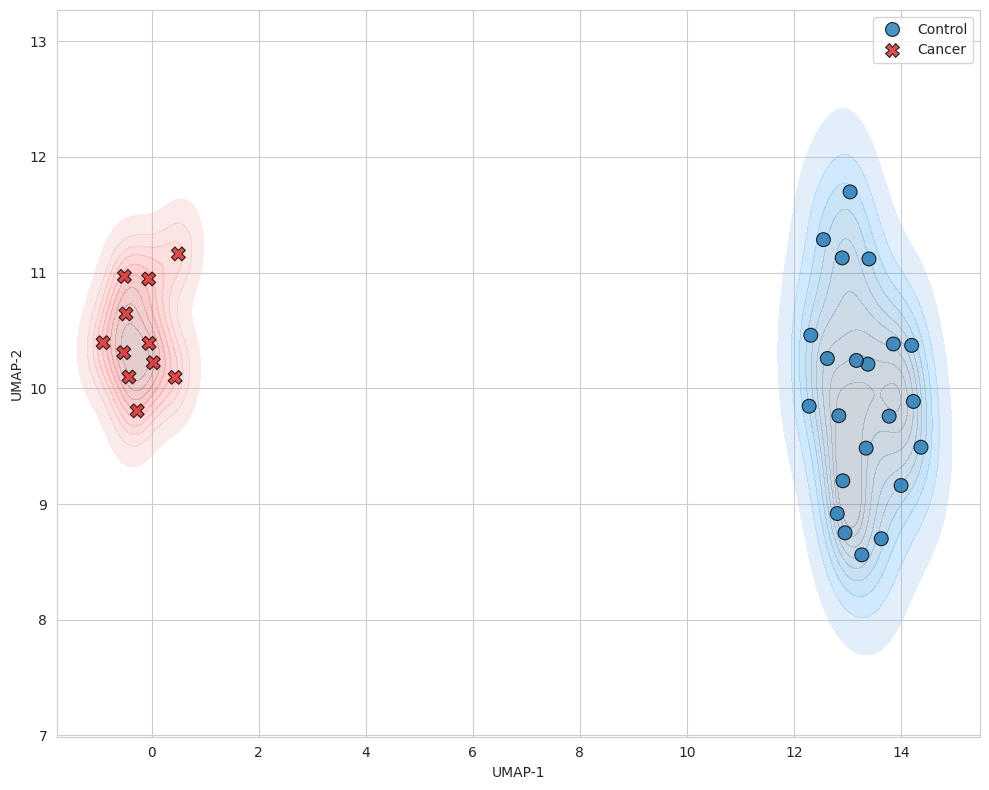

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns


df_plot = pd.DataFrame({
    'x': coords_2d[:,0],
    'y': coords_2d[:,1],
    'label': labels,
    'patient_id': patient_ids
})
df_plot['diagnosis'] = df_plot['label'].map({0: 'Control', 1: 'Cancer'})

palette = {
    'Cancer': '#D62728',   # red
    'Control': '#1F77B4'   # blue
}

plt.figure(figsize=(10, 8))

for label, group in df_plot.groupby('diagnosis'):
    sns.kdeplot(
        x=group['x'],
        y=group['y'],
        fill=True,
        alpha=0.25,
        linewidth=1.5,
        label=f"{label} Region",
        color=palette[label] 
    )

sns.scatterplot(
    data=df_plot,
    x='x',
    y='y',
    hue='diagnosis',
    style='diagnosis',
    palette=palette,
    s=100,
    alpha=0.8,
    edgecolor='black'
)

plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend()
plt.tight_layout()
plt.show()
